# **Discovering fraud detection with tree-based Classification Model and Causal Study**
*Author: Krystal Qiu, Kaiyuan Huang, Jiangqi Wu, Gefei Shen*

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, average_precision_score,
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, brier_score_loss, log_loss,
    classification_report, precision_recall_curve, roc_curve
)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier



### Library Dependencies

Our workflow relies on the following core libraries:

#### **pandas**
Used for all data handling tasks, including loading the dataset, inspecting features, cleaning invalid values, and constructing the final modeling DataFrame.

#### **matplotlib**
Used to generate visualizations such as histograms, missingness plots, and precision-recall curves, helping us interpret both the raw data and model performance.

#### **scikit-learn**
Central to our modeling pipeline. We use it for:
- preprocessing (e.g., one-hot encoding, column transformers)
- splitting the dataset
- training baseline models (Decision Tree)
- evaluating models (Precision@K, PR-AUC, precision-recall curves)
- handling imbalance through class weights

#### **xgboost**
Used for our final, more advanced model. XGBoost naturally handles missing values and is well-suited for imbalanced, tabular fraud-detection data.

#### **imblearn**
Used specifically for SMOTE to experiment with oversampling the minority fraud class and to compare against class-weighted models.

These libraries together provide all the components needed for data cleaning, visualization, modeling, and evaluation in this study.




## **1. Motivation & Research Question**
Online credit and lending platforms process large volumes of applications every day, but only a very small fraction are fraudulent. Despite their rarity, fraudulent applications create significant financial losses, making early detection essential. This dataset contains a wide range of behavioral, demographic, device, and application-level features that may help identify risky patterns. However, the severe class imbalance and the presence of missing or irregular values make the problem challenging and require careful preprocessing and modeling.

**Research Question:**  
Can we build a reliable model to distinguish fraudulent applications from legitimate ones using the features provided?  
Additionally, are certain behaviors—such as not reporting previous address history or submitting a foreign-origin request—associated with a systematically higher risk of fraud?

Our analysis aims to (1) explore the data structure and key patterns, (2) build predictive models under heavy imbalance, and (3) investigate whether specific applicant behaviors meaningfully elevate fraud risk.



## **2. Data Overview**
This dataset contains one million application records with 32 features capturing user demographics, address history, device information, behavioral metrics, and application details. The target variable, `fraud_bool`, indicates whether an application was confirmed as fraudulent (1) or legitimate (0). Because fraud cases are extremely rare, understanding the data structure and quality is crucial before modeling.

In this section, we introduce the dataset, inspect its dimensions, preview a small sample of rows, and begin forming an initial sense of which features may require additional preprocessing (such as handling missing values encoded as `-1`, heterogeneous data types, or potentially skewed numeric variables).

### 2.1 Importing the data

In [ ]:
df = pd.read_csv('Base.csv')
print(df.shape)
df.head()

(1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


### 2.2 Summary of the Data
Although the dataset reports no formal missing values (`NaN`), several features use special codes—most commonly `-1`—to indicate missing or invalid entries. This means the dataset appears complete at first glance, but in practice contains structural missingness that must be handled carefully during preprocessing.

The data types overview also shows a mix of numerical and categorical features. Many numeric fields represent behavioral or time-based quantities, while several categorical variables (such as `payment_type`, `employment_status`, and `housing_status`) will require encoding before modeling. Together, these checks help establish the data structure and highlight the need for additional cleaning steps, especially around nonstandard missing value indicators.


In [ ]:
# Assess missingness in the dataset
print("Total missing values:", df.isna().sum().sum())

Total missing values: 0


In [ ]:
# Check feature type
df.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

### 2.3 Features Description
This table summarizes all features in the dataset, including their types, value ranges, and brief descriptions.  
Having a clear understanding of each variable is important before modeling, since many features have special encodings (such as `-1` for missing values), heavy skew, or high cardinality. These characteristics influence how we handle preprocessing, choose modeling strategies, and interpret results later on.


| Column | Type | Range / Values | Description | Notes |
|---|---|---|---|---|
| `fraud_bool` | binary | {0,1} | Fraud label (1 = fraud, 0 = legit). | Highly imbalanced (~1.1% fraud). |
| `income` | numeric (continuous, quantile) | [0, 1] | Applicant's annual income, quantile-scaled. | Mean ≈ 0.56, SD ≈ 0.29. |
| `name_email_similarity` | numeric (continuous) | [0, 1] | Similarity between applicant name and email. Higher = more similar. | Mean ≈ 0.49, SD ≈ 0.29. |
| `prev_address_months_count` | integer | [−1, 380] | Months at previous address. | `-1` encodes missing. Heavy mass at `-1`. |
| `current_address_months_count` | integer | [−1, 406] | Months at current address. | `-1` encodes missing. Median ≈ 130. |
| `customer_age` | integer (binned by decade start) | [10, 90] | Age bucket (e.g., 20 means 20-29). | Mean ≈ 33.7, SD ≈ 12. |
| `days_since_request` | numeric (continuous) | [0, 78.5] | Days since application submission. | Heavily right-skewed; most < 2 days. |
| `intended_balcon_amount` | numeric (continuous) | [−15.5, 113] | Initial transferred amount for the application. | Negative values present; large mass near ~0 to small positives. |
| `payment_type` | categorical (5) | {AA, AB, …} | Credit payment plan type (anonymized). | Most common: `AB` (37%), `AA` (26%). |
| `zip_count_4w` | integer | [1, 6700] | # applications in same ZIP over last 4 weeks. | Mean ≈ 1.57k, SD ≈ 1.01k. |
| `velocity_6h` | numeric (continuous) | [−211, 16700] | Avg applications/hour in last 6 hours. | Mean ≈ 5.67k, SD ≈ 3.01k. |
| `velocity_24h` | numeric (continuous) | [1300, 9527] | Avg applications/hour in last 24 hours. | Mean ≈ 4.77k, SD ≈ 1.48k. |
| `velocity_4w` | numeric (continuous) | [2779, 7043] | Avg applications/hour in last 4 weeks. | Mean ≈ 4.86k, SD ≈ 0.92k. |
| `bank_branch_count_8w` | integer | [0, 2385] | # applications in selected branch in last 8 weeks. | Highly zero-inflated (~82%). |
| `date_of_birth_distinct_emails_4w` | integer | [0, 39] | # distinct emails sharing same DOB in 4 weeks. | Mean ≈ 9.5, SD ≈ 5.03. |
| `employment_status` | categorical (7) | {CA, CB, …} | Applicant employment status (anonymized). | Most common: `CA` (73%), `CB` (14%). |
| `credit_risk_score` | numeric (continuous) | [−176, 389] | Internal application risk score. | Mean ≈ 131, SD ≈ 69.7. |
| `email_is_free` | binary | {0,1} | Email domain type (1 = free provider). | Mean ≈ 0.53. |
| `housing_status` | categorical (7) | {BC, BB, …} | Applicant residential status (anonymized). | Most common: `BC` (37%), `BB` (26%). |
| `phone_home_valid` | binary | {0,1} | Validity of home phone. | Mean ≈ 0.42 (many invalid/missing). |
| `phone_mobile_valid` | binary | {0,1} | Validity of mobile phone. | Mean ≈ 0.89 (mostly valid). |
| `bank_months_count` | integer | [−1, 31] | Months since prior bank account opened. | `-1` encodes missing. |
| `has_other_cards` | binary | {0,1} | Holds other cards from same bank. | Mean ≈ 0.22. |
| `proposed_credit_limit` | integer | [200, 2100] | Proposed credit limit. | Multimodal at ~200, ~500, ~1500. |
| `foreign_request` | binary | {0,1} | Request originated outside bank's country. | Mean ≈ 0.03. |
| `source` | categorical (2) | {INTERNET, TELEAPP} | Application source (browser vs. app/tele). | `INTERNET` ≈ 99%. |
| `session_length_in_minutes` | numeric (continuous) | [−1, 85.9] | Web session duration in minutes. | `-1` may flag special/missing; median ≈ 5-9. |
| `device_os` | categorical (5) | {Windows, Macintox, Linux, X11, other} | Device operating system. | Top: `other` (34%), `linux` (33%). |
| `keep_alive_session` | binary | {0,1} | “Keep me logged in” preference. | Mean ≈ 0.58. |
| `device_distinct_emails_8w` | integer | [0, 2] | Distinct emails from the device in 8 weeks. | Median = 1; rare `-1` in bins indicates artifacts. |
| `device_fraud_count` | integer | {0,1} | # fraudulent apps from device. | All zeros in sample. |
| `month` | integer | [0, 7] | Month index of application (anonymized span). | Mean ≈ 3.29, SD ≈ 2.21. |

### Encoding & Quality Notes
- Special missing codes: several duration/tenure fields use `-1` to indicate missing (`prev_address_months_count`, `current_address_months_count`, `bank_months_count`, occasionally `session_length_in_minutes` bin).
- Class imbalance: `fraud_bool` is ~1.1% positive; consider stratification, AUCPR, class weights, or focal loss.
- Heavy discretization: many features are binned or quantile-scaled; treat as ordered numeric unless your model benefits from categorical handling.

## **3. Exploratory Data Analysis and Data Preprocessing**
In this section, we explore the structure and distributions of key features to understand overall data quality and identify patterns relevant to fraud detection. We examine the class imbalance, inspect unusual value encodings such as `-1`, and look for skewed or heavy-tailed variables. These insights guide our preprocessing choices and help us anticipate which features may contribute most to the modeling stage.


### 3.1: Imbalance Fraud Status
The distribution of the target variable, `fraud_bool`, is highly imbalanced. The vast majority of transactions are labeled as non-fraudulent (0), while only a very small fraction are fraudulent (1). This indicates that fraudulent activity is rare in the dataset, which is typical in fraud detection tasks.

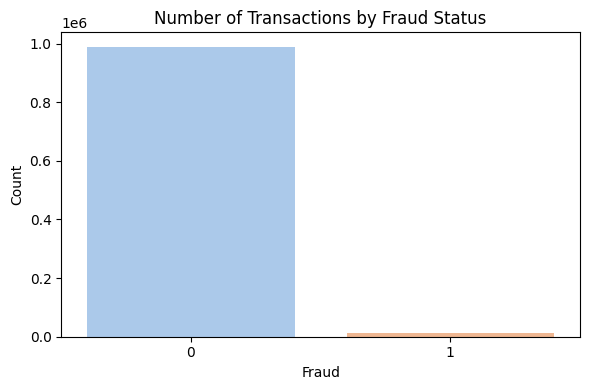

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df,
    x='fraud_bool',
    hue='fraud_bool',
    palette='pastel',
    legend=False
)

plt.title('Number of Transactions by Fraud Status', fontsize=12)
plt.xlabel('Fraud', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()
plt.show()

### 3.2: Fraud Rate by Missingness
We flag `-1` values as missing and compare fraud rates across missing vs. non-missing groups. This helps determine whether missingness is informative, with specific findings summarized later.

In [ ]:
eda_df = df.copy()
target = "fraud_bool"

# columns where -1 indicates missing
cols = [
    "prev_address_months_count",
    "current_address_months_count",
    "bank_months_count",
    "session_length_in_minutes",
    "device_distinct_emails_8w"
]

for c in cols:
    eda_df[c + "_is_missing"] = eda_df[c].eq(-1) | eda_df[c].isna()
    eda_df[c] = eda_df[c].replace(-1, np.nan)

summary = []
for c in cols:
    miss_mask = eda_df[c + "_is_missing"]
    fraud_missing = eda_df.loc[miss_mask, target].mean()
    fraud_present = eda_df.loc[~miss_mask, target].mean()
    lift = fraud_missing / fraud_present if fraud_present > 0 else np.nan

    summary.append({
        "feature": c,
        "% missing": round(miss_mask.mean() * 100, 2),
        "fraud_rate_missing": round(fraud_missing, 4),
        "fraud_rate_present": round(fraud_present, 4),
        "lift_missing_vs_present": round(lift, 2)
    })

summary_df = pd.DataFrame(summary)
print("Missingness vs Fraud summary:")
display(summary_df)

Missingness vs Fraud summary:


,feature,% missing,fraud_rate_missing,fraud_rate_present,lift_missing_vs_present
0,prev_address_months_count,71.29,0.0142,0.0031,4.56
1,current_address_months_count,0.43,0.0033,0.0111,0.30
2,bank_months_count,25.36,0.0163,0.0092,1.77
3,session_length_in_minutes,0.20,0.0089,0.0110,0.81
4,device_distinct_emails_8w,0.04,0.0111,0.0110,1.01


#### 3.2.1 Aggregate Table Column Explanation
- **% missing** – Percentage of records where the feature value is missing (encoded as -1 or NaN).
- **fraud_rate_missing** – The proportion of fraudulent accounts (fraud_bool = 1) among records - where the feature is missing.
- **fraud_rate_present** – The proportion of fraudulent accounts among records where the feature is present (non-missing).
- **lift_missing_vs_present** – The ratio of fraud rates (fraud_rate_missing / fraud_rate_present).
    - **Values > 1** → higher fraud rate when missing → missingness may be predictive.
    - **Values < 1**→ lower fraud rate when missing → missingness likely not predictive.

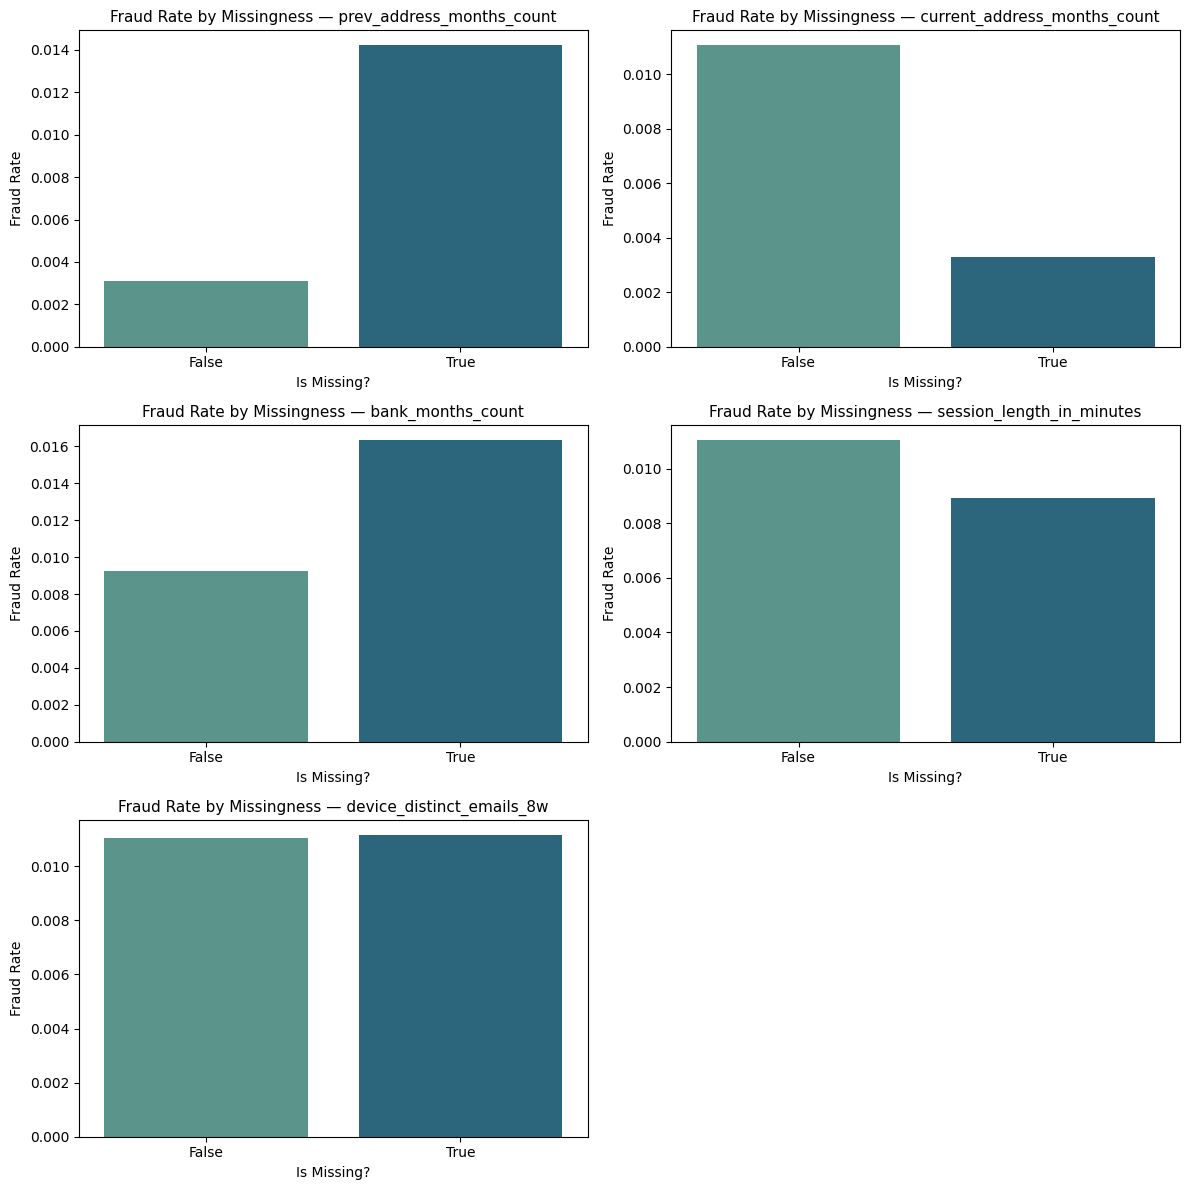

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, c in enumerate(cols[:5]):
    missing_col = f"{c}_is_missing"

    sns.barplot(
        data=eda_df,
        x=missing_col,
        y=target,
        hue=missing_col,
        palette="crest",
        ax=axes[i],
        errorbar=None,
        dodge=False,
        legend=False
    )

    axes[i].set_title(f"Fraud Rate by Missingness — {c}", fontsize=11)
    axes[i].set_xlabel("Is Missing?")
    axes[i].set_ylabel("Fraud Rate")
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

#### 3.2.2 Findings on Missingness Bar Plot
From the missingness analysis, I found that `prev_address_months_count` shows a strong link with fraud. About 71% of its values are missing, and the fraud rate for those missing entries (1.42%) is roughly 4.6× higher than for non-missing ones (0.31%). This suggests that applicants who did not provide their previous address history are more likely to be fraudulent, so adding a missing flag for this variable could be valuable in modeling.

Meanwhile, `current_address_months_count`, `session_length_in_minutes` and `device_distinct_emails_8w` have very few missing values (below 0.5%) and show little or even reversed differences in fraud rate. Their missingness likely has no predictive power and can be ignored or imputed normally.

Lastly, `bank_months_count` has a moderate missing rate (25.36%) and slightly higher fraud rate for missing values (1.63% vs 0.92%). This weak positive relationship might still be worth exploring, but it’s less strong compared to the previous address feature.

### 3.3: Distribution of Numerical Columns

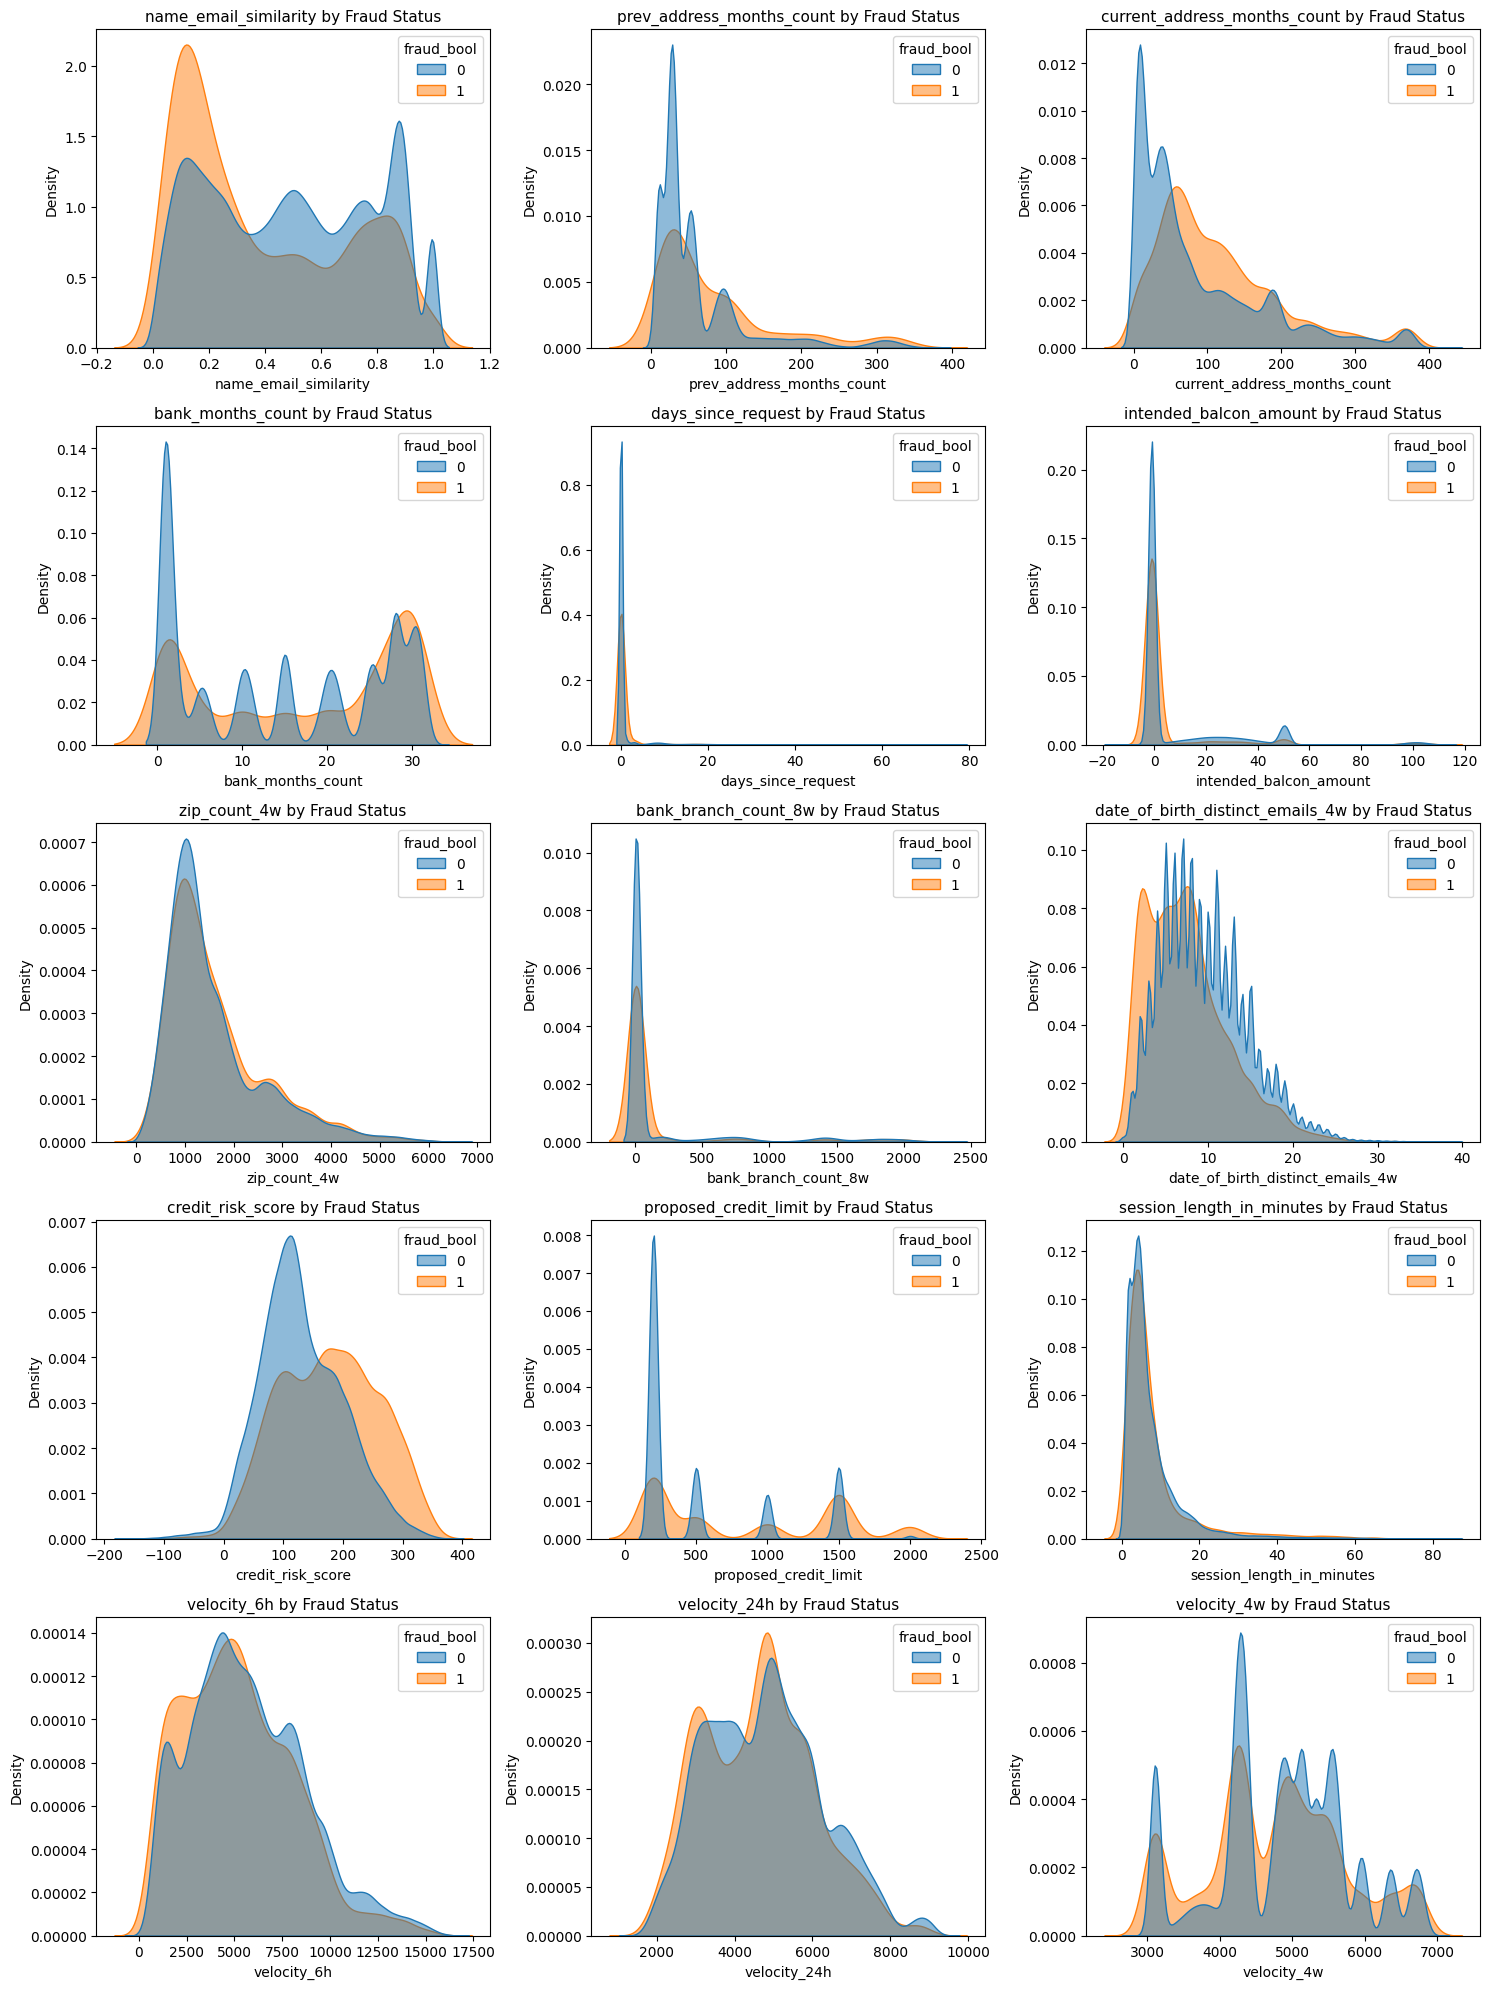

In [ ]:

# manually selected numeric (continuous) features
num_cols = [
    'name_email_similarity',
    'prev_address_months_count',
    'current_address_months_count',
    'bank_months_count',
    'days_since_request',
    'intended_balcon_amount',
    'zip_count_4w',
    'bank_branch_count_8w',
    'date_of_birth_distinct_emails_4w',
    'credit_risk_score',
    'proposed_credit_limit',
    'session_length_in_minutes',
    'velocity_6h',
    'velocity_24h',
    'velocity_4w'
]

# set up grid: 3 plots per row
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(
        data=eda_df, x=col, hue='fraud_bool',
        fill=True, common_norm=False, alpha=0.5, ax=axes[i]
    )
    axes[i].set_title(f'{col} by Fraud Status', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### 3.3.1 Findings on Distribution of Numerical Columns
We plot all the numerical features' distributions, and below are the two key findings from noticeable distribution differences:

1) `name_email_similarity`: Fraudulent accounts tend to be more clustered at the lower end with low similar score, likely because scammers use throwaway or mismatched emails that do not resemble the provided name.
2)  `credit_risk_score`: Fraud accounts tend to have higher risk scores. The shift is pretty clear compared to non-fraud cases, so this feature is likely important.


### 3.4 Imputation of Negative Values (missing or invalid data)

#### 3.4.1 Distribution of Numerical Columns with Negative Values

This helper function identifies all numeric columns that contain negative values and visualizes their distributions. Since negative values in this dataset usually represent missing or invalid entries, plotting these columns helps confirm which features require imputation. The function returns the list of affected columns, which we use in the subsequent preprocessing steps.



Features with negative values (8): ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'velocity_6h', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']


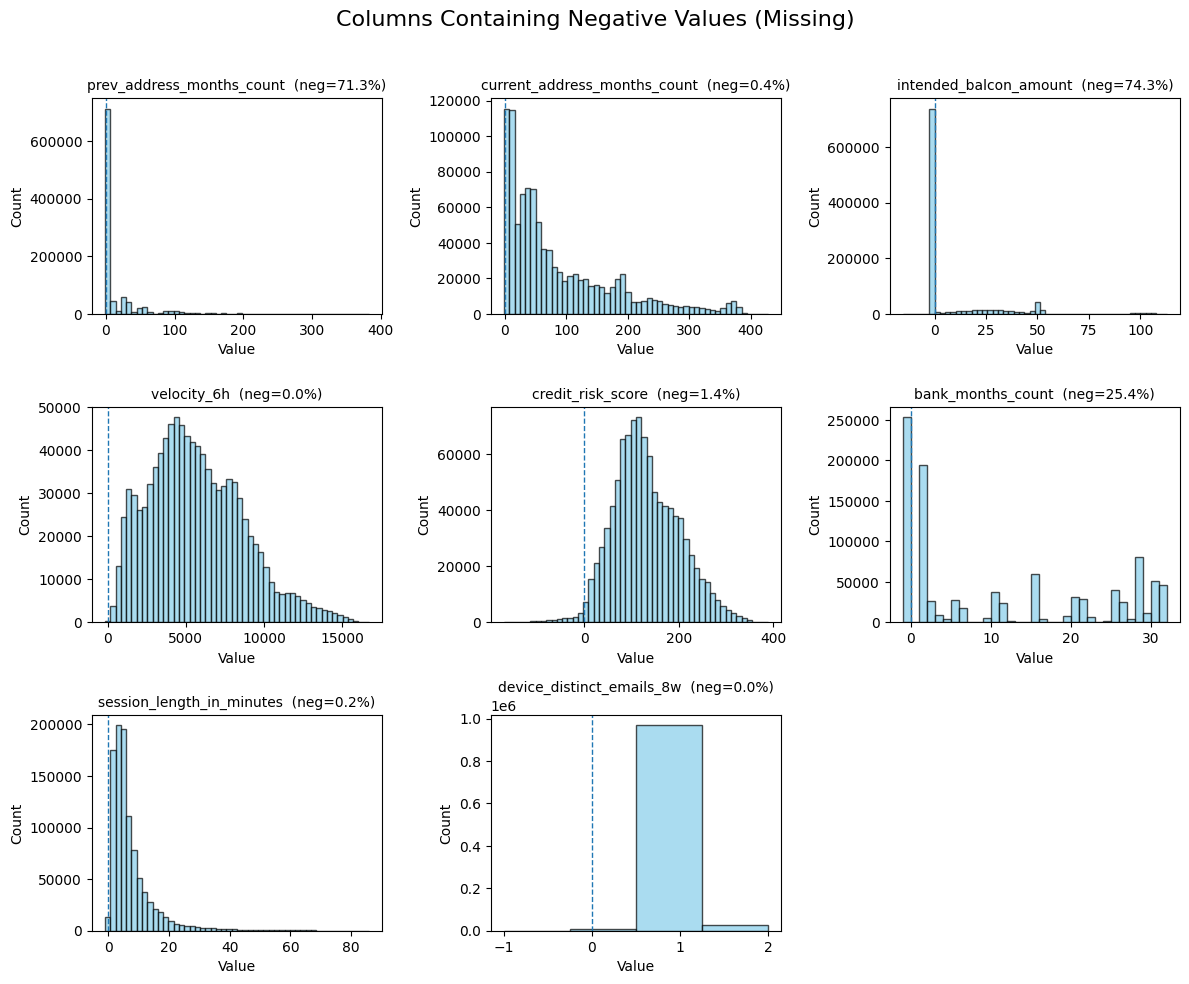

In [ ]:
def list_and_plot_negative_columns(df, bins=50, ncols=3):
    num_cols = df.select_dtypes(include=[np.number]).columns

    neg_cols = []
    for c in num_cols:
        s = pd.to_numeric(df[c], errors='coerce')
        if s.min(skipna=True) < 0:
            neg_cols.append(c)

    print(f"Features with negative values ({len(neg_cols)}): {neg_cols}")

    nrows = math.ceil(len(neg_cols) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.2*nrows))
    axes = np.ravel(axes)

    for ax, col in zip(axes, neg_cols):
        s = pd.to_numeric(df[col], errors='coerce').dropna()
        uniq = s.nunique()
        use_bins = min(max(uniq, 2), bins) if uniq <= 50 else bins
        ax.hist(s, bins=use_bins, color='skyblue', edgecolor='black', alpha=0.7)
        ax.axvline(0, linestyle='--', linewidth=1)
        neg_pct = (s < 0).mean()
        ax.set_title(f"{col}  (neg={neg_pct:.1%})", fontsize=10)
        ax.set_xlabel("Value", fontsize=10)
        ax.set_ylabel("Count", fontsize=10)

    for ax in axes[len(neg_cols):]:
        ax.set_visible(False)
    fig.suptitle("Columns Containing Negative Values (Missing)", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    return neg_cols

neg_cols = list_and_plot_negative_columns(df, bins=50, ncols=3)
neg_cols.remove("credit_risk_score")

#### 3.4.2 Median Imputation and Missingness Indicator
The histogram analysis revealed several features with negative values that likely indicate missing or invalid data. By checking the description of these features, we confirmed that except for `credit_risk_score`, negative values in other features are indeed indicators of missingness or invalid entries.

Here, for features with negative values indicating invalid data or missingness, we impute them with the median of the non-negative values.

From the previous missingness analysis, we identified some features where missingness is predictive of fraud, so we create additional binary flag columns to indicate missingness before imputation.

In [ ]:
Missing = {
    'prev_address_months_count',
    "current_address_months_count",
    "bank_months_count",
    "session_length_in_minutes",
    "device_distinct_emails_8w",
}

audit = []
df_imputed = df.copy(deep=True)

for c in neg_cols:
    s = pd.to_numeric(df_imputed[c], errors='coerce')

    missing_mask = (s == -1)
    invalid_mask = (s < -1)
    impute_mask = missing_mask | invalid_mask

    n_missing = int(missing_mask.sum())
    n_invalid = int(invalid_mask.sum())
    n_impute  = int(impute_mask.sum())

    if c in Missing:
        df_imputed[c + "_is_missing"] = missing_mask.astype(int)

    if n_impute == 0:
        audit.append({
            "column": c,
            "impute_value": np.nan,
            "n_missing": n_missing,
            "n_invalid": n_invalid,
            "n_imputed": 0,
            "note": "no_-1_or_invalid_negatives",
        })
        continue

    non_bad = s[~impute_mask]
    if non_bad.size == 0:
        audit.append({
            "column": c,
            "impute_value": np.nan,
            "n_missing": n_missing,
            "n_invalid": n_invalid,
            "n_imputed": n_impute,
            "note": "skipped_no_clean_values",
        })
        continue

    med = float(non_bad.median())
    if pd.api.types.is_integer_dtype(df_imputed[c].dtype) and pd.notna(med):
        med = int(round(med))

    df_imputed.loc[impute_mask, c] = med

    audit.append({
        "column": c,
        "impute_value": med,
        "n_missing": n_missing,
        "n_invalid": n_invalid,
        "n_imputed": n_impute
    })

audit_df = pd.DataFrame(audit)
print(audit_df)

                         column  impute_value  n_missing  n_invalid  n_imputed
0     prev_address_months_count     34.000000     712920          0     712920
1  current_address_months_count     53.000000       4254          0       4254
2        intended_balcon_amount     -0.445582          0     379602     379602
3                   velocity_6h   5319.876977          0         44         44
4             bank_months_count     15.000000     253635          0     253635
5     session_length_in_minutes      5.122832       2015          0       2015
6     device_distinct_emails_8w      1.000000        359          0        359


#### 3.4.3 Feature Visualization after Imputation
After completing the imputation steps, we visualize a sample of numeric features to verify that the distributions look reasonable and that no unintended distortions were introduced. These histograms allow us to confirm that median imputation handled negative or invalid entries appropriately and that the added missingness indicators behave as expected. This quick check helps ensure data quality before proceeding to modeling.

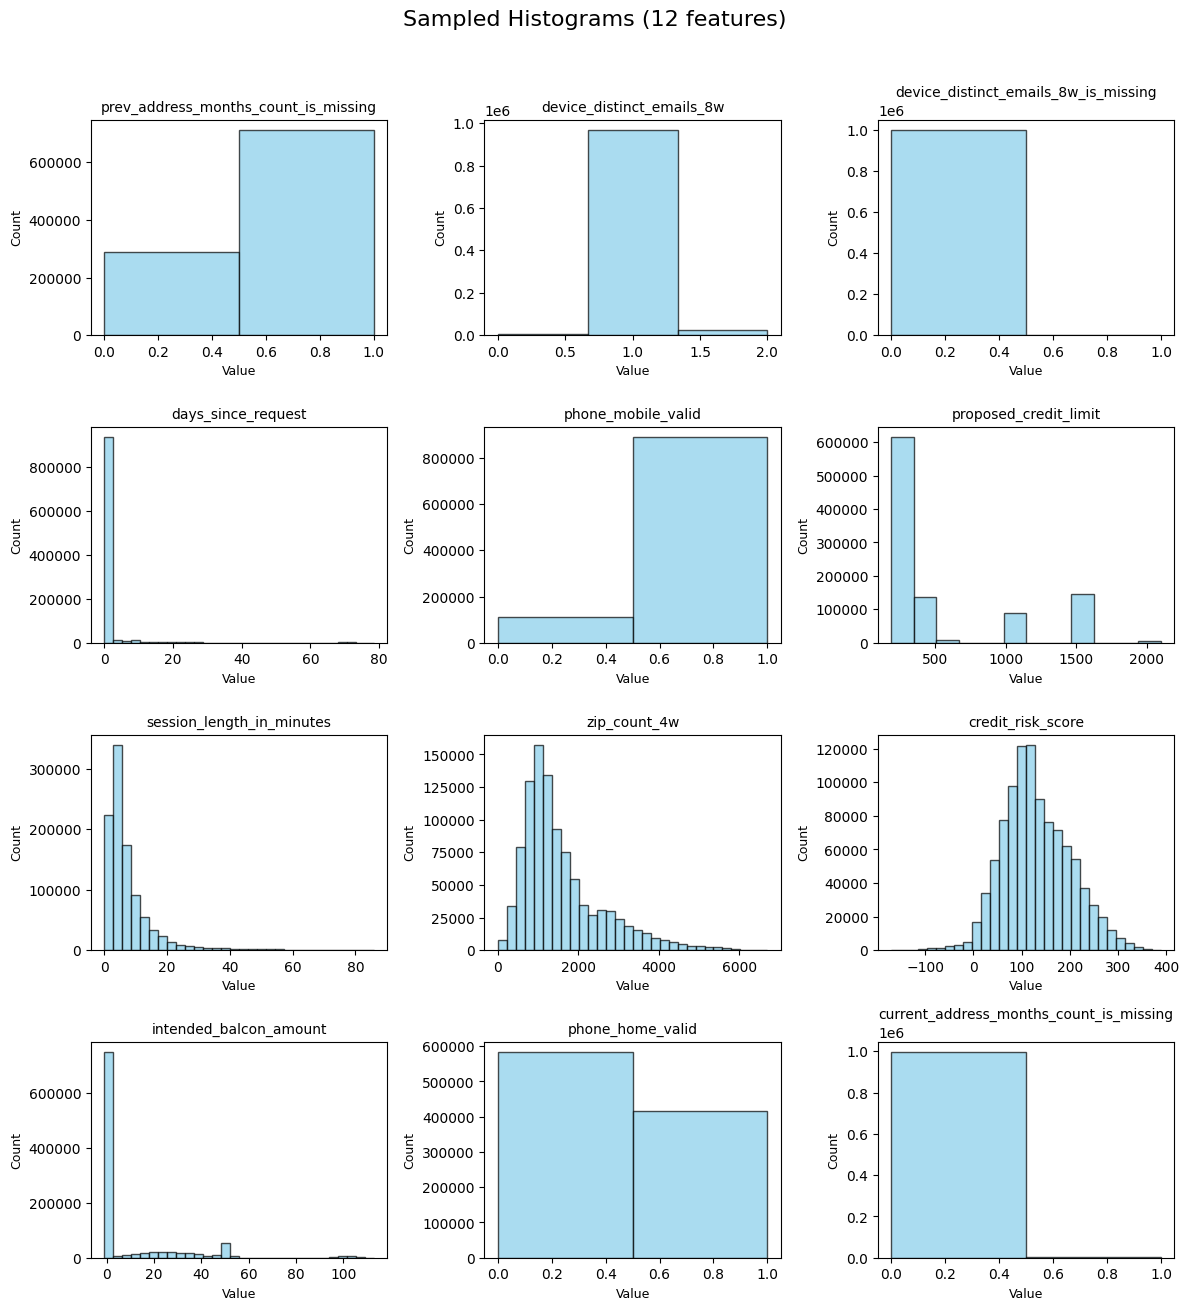

In [ ]:
def plot_sampled_histograms(df, n=12, rows=4, cols=3, random_state=50, bins=30, columns=None):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if columns is not None:
        plot_cols = [c for c in columns if c in numeric_cols]
    else:
        rng = np.random.default_rng(random_state)
        plot_cols = (rng.choice(numeric_cols, size=n, replace=False).tolist()
                     if len(numeric_cols) >= n else numeric_cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols*4.0, rows*3.2))
    axes = np.ravel(axes)

    for ax, col in zip(axes, plot_cols):
        s = df[col].dropna()
        uniq = s.nunique(dropna=True)
        use_bins = min(max(uniq, 2), bins) if uniq <= 20 else bins
        ax.hist(s, bins=use_bins, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(col, fontsize=10)
        ax.set_ylabel("Count", fontsize=9)
        ax.set_xlabel("Value", fontsize=9)

    for ax in axes[len(plot_cols):]:
        ax.set_visible(False)

    fig.suptitle("Sampled Histograms ({} features)".format(len(plot_cols)), y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    return plot_cols

sampled_cols = plot_sampled_histograms(df_imputed)

### 3.5 Correlation Analysis
From the correlation heatmap, we can see there is weak correlation among 'velocity_6h', 'velocity_24h', and 'velocity_4w'. Also, 'proposed_credit_limit' has a moderate positive correlation with 'credit_risk_score'. Other than these, there is no strong correlation between any two numeric features.



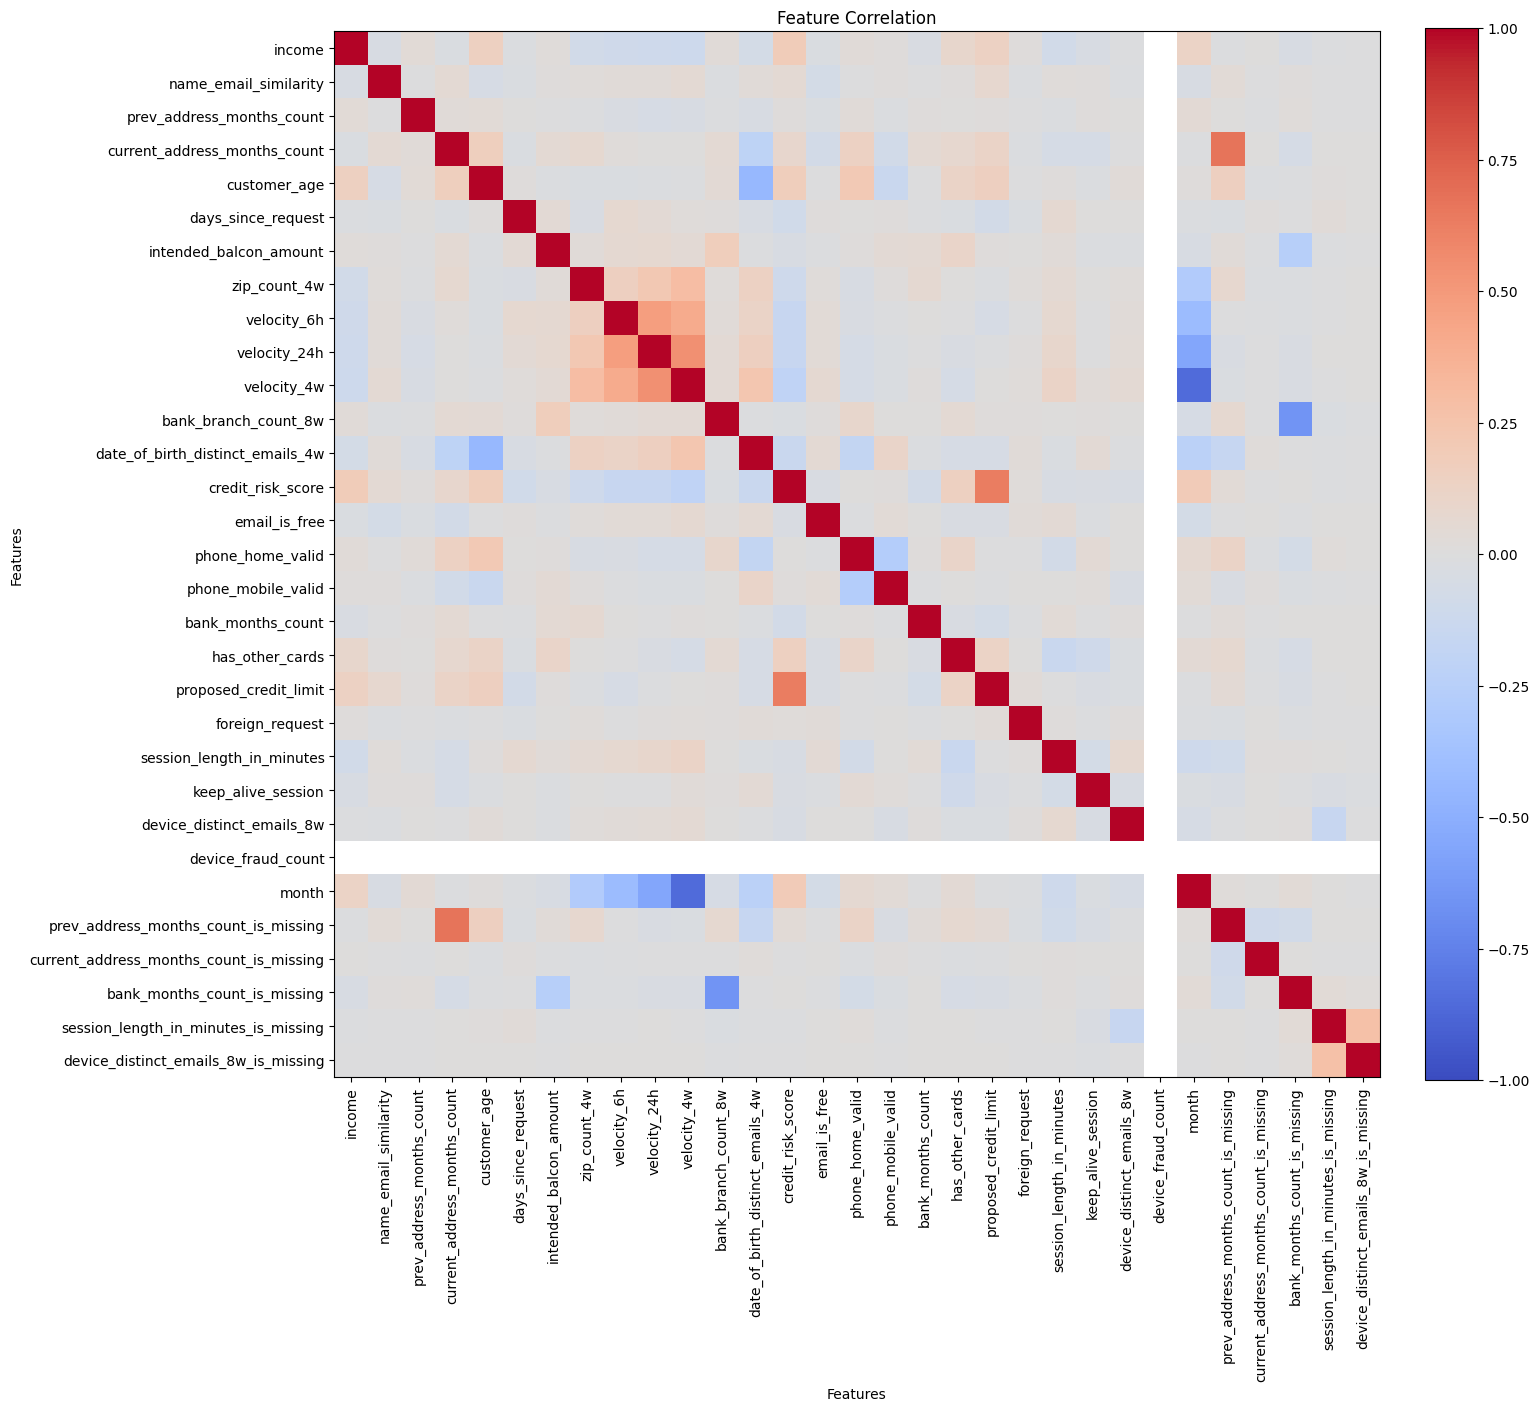

In [ ]:
X = df_imputed.drop(columns=['fraud_bool'], errors='ignore').copy()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
corr = X[num_cols].corr(method='spearman')
n = corr.shape[0]
figsize = (max(6, 0.5*n), max(6, 0.5*n))

fig, ax = plt.subplots(figsize=figsize)
im = ax.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Feature Correlation')
ax.set_xlabel('Features')
ax.set_ylabel('Features')
ax.set_xticks(range(n))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(n))
ax.set_yticklabels(corr.index)
plt.tight_layout()
plt.show()

## **4. Baseline Model**

### 4.1 Baseline Model Overview

To establish a reference point for model performance, we first train a baseline classifier using a decision tree with `class_weight='balanced'`. This ensures the model accounts for the severe class imbalance without relying on synthetic oversampling. Only the cleaned and imputed features are used, and missingness indicator columns are intentionally excluded to evaluate the model's performance before adding more informative engineered features.

Before fitting, all numeric features are passed through a passthrough transformer, while categorical variables are one-hot encoded. We sample the first 100,000 observations to make training more efficient while still preserving the natural ratio between fraudulent and legitimate cases. The dataset is then split using a stratified train-test split to maintain class proportions across sets.

**Why Decision Tree?**

A decision tree provides a simple and interpretable starting point. It can capture nonlinear relationships without extensive tuning and offers a meaningful benchmark against which more complex models (Random Forests, XGBoost, etc.) can later be compared. Using `class_weight='balanced'` helps offset the low fraud rate without artificially changing the data distribution.


In [ ]:
#dropped missing indicator, will be included in the final
missing_indicators = [c for c in df_imputed.columns if c.endswith("_is_missing")]

df_model = df_imputed.drop(columns=missing_indicators).copy()[:100000]

y = df_model['fraud_bool'].astype(int)
X = df_model.drop(columns=['fraud_bool'])

# Convert bool to int
bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype("Int8")

# Column classification
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='drop'
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# No Smote
baseline_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', DecisionTreeClassifier(
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])

baseline_clf.fit(X_train, y_train)
proba_base = baseline_clf.predict_proba(X_test)[:, 1]


#With Smote
smote_clf = ImbPipeline(steps=[
    ('prep', preprocess),
    ('smote', SMOTE(sampling_strategy=0.2, random_state=42)),
    ('model', DecisionTreeClassifier(
        max_depth=None,
        random_state=42
    ))
])

smote_clf.fit(X_train, y_train)
proba_smote = smote_clf.predict_proba(X_test)[:, 1]


### 4.2 Evaluation Metrics: Precision@K and PR–AUC

Fraud detection is an extreme class-imbalance problem: only ~1% of observations are fraudulent.  
Traditional metrics like accuracy or ROC–AUC are misleading here, because a model predicting “non-fraud” for all observations would still achieve extremely high accuracy.

To properly measure performance, we use two metrics that directly reflect how well the model identifies rare positive cases.

---

#### Precision@K  
Precision@K evaluates the precision among the model’s top-ranked K predictions.  
This is crucial in fraud settings because:

- Investigators have limited capacity.  
- Companies typically review only the **top K most suspicious** applications.  
- A model is useful only if these top K cases contain a high proportion of true fraud.

Thus, Precision@K directly measures *operational value* rather than overall accuracy.

We report multiple K values (50, 100, 200, 500, 1000) to reflect different investigation budgets.

---

#### PR–AUC (Precision–Recall AUC)  
The Precision–Recall curve focuses on the tradeoff between detecting fraud (recall) and avoiding excessive false alarms (precision).  
This metric is far more informative than ROC–AUC when positives are rare because:

- Precision emphasizes the **quality** of flagged fraud cases.  
- Recall emphasizes **coverage** of fraud cases.  
- PR–AUC summarizes performance across all thresholds.

A higher PR–AUC means the model achieves both strong fraud detection and prioritized accuracy among predicted fraud cases.

Together, Precision@K and PR–AUC give a complete picture of model performance in a real-world fraud investigation workflow.


                 Model     K  Precision@K
0  Baseline (No SMOTE)    50        0.020
1          SMOTE (1:5)    50        0.020
2  Baseline (No SMOTE)   100        0.060
3          SMOTE (1:5)   100        0.030
4  Baseline (No SMOTE)   200        0.070
5          SMOTE (1:5)   200        0.025
6  Baseline (No SMOTE)   500        0.040
7          SMOTE (1:5)   500        0.022
8  Baseline (No SMOTE)  1000        0.025
9          SMOTE (1:5)  1000        0.016

PR-AUC (Baseline): 0.016
PR-AUC (SMOTE): 0.0121


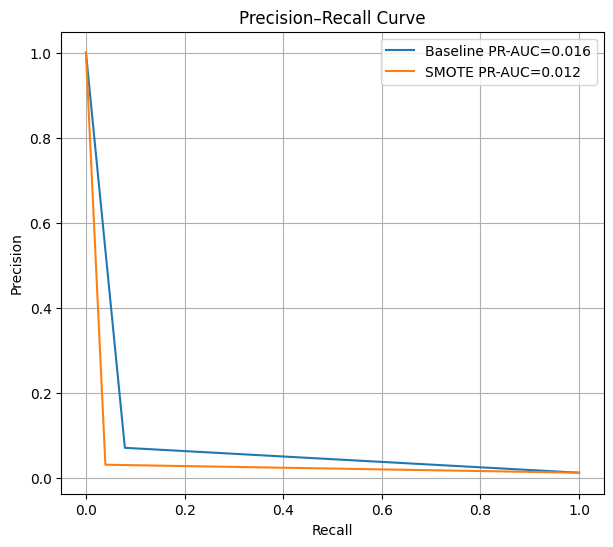

In [ ]:



# RECISION @ K
def precision_at_k(y_true, proba, k):
    df = pd.DataFrame({"y": y_true, "proba": proba})
    df_sorted = df.sort_values("proba", ascending=False)
    top_k = df_sorted.head(k)
    return top_k["y"].mean()

Ks = [50, 100, 200, 500, 1000]

precision_rows = []

for k in Ks:
    precision_rows.append({
        "Model": "Baseline (No SMOTE)",
        "K": k,
        "Precision@K": precision_at_k(y_test, proba_base, k)
    })
    precision_rows.append({
        "Model": "SMOTE (1:5)",
        "K": k,
        "Precision@K": precision_at_k(y_test, proba_smote, k)
    })

precision_df = pd.DataFrame(precision_rows)
print(precision_df.round(4))

# PR-AUC
pr_auc_base = average_precision_score(y_test, proba_base)
pr_auc_smote = average_precision_score(y_test, proba_smote)

print("\nPR-AUC (Baseline):", round(pr_auc_base, 4))
print("PR-AUC (SMOTE):", round(pr_auc_smote, 4))



# PLOT PRECISION-RECALL CURVE

plt.figure(figsize=(7, 6))

prec_base, rec_base, _ = precision_recall_curve(y_test, proba_base)
prec_sm, rec_sm, _ = precision_recall_curve(y_test, proba_smote)

plt.plot(rec_base, prec_base, label=f"Baseline PR-AUC={pr_auc_base:.3f}")
plt.plot(rec_sm, prec_sm, label=f"SMOTE PR-AUC={pr_auc_smote:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

### 4.3 Interpretation of Output
The Precision@K results show that SMOTE does not improve model performance in our setting. At K = 50, both models achieve a precision of 2%, meaning only 1 out of the top 50 flagged cases is truly fraudulent. At K = 100, the baseline model performs substantially better, reaching 6% precision compared with 3% under SMOTE. This suggests that the baseline model is more effective at ranking the highest-risk cases. The PR-AUC values reinforce this finding: the baseline achieves 0.016, outperforming SMOTE’s 0.012 despite the extreme class imbalance. The Precision–Recall curve also remains consistently higher for the baseline without SMOTE, indicating stronger overall ranking ability. Taken together, these results show that class_weight='balanced' is sufficient for this dataset, while SMOTE introduces noise that degrades the model’s ability to identify the small number of true fraud cases at the top of the risk list.

## **5. Causal Approach**

### 5.1 Effect of “not providing previous address history” on fraud risk.

To estimate whether *not providing previous address history* causally increases fraud risk, we treat  
**T = 1** when `prev_address_months_count = -1` (missing), and **T = 0** otherwise.  
The outcome is the fraud indicator (`fraud_bool`).

We estimate the causal effect using **Inverse Probability Weighting (IPW)**:  
1. Model the propensity score \( e(x) = P(T=1 \mid X) \) using all other features.  
2. Reweight observations to approximate a randomized treatment assignment.  

In [ ]:
df_causal = df.copy().iloc[:100000].reset_index(drop=True)

# Outcome: fraud
Y = df_causal["fraud_bool"].astype(int)

# Treatment: 1 if prev_address_months_count == -1 (missing), 0 otherwise
df_causal["t_missing_prev_addr"] = (df_causal["prev_address_months_count"] == -1).astype(int)
T = df_causal["t_missing_prev_addr"]

print("Treatment rate (missing prev address):")
print(T.value_counts(normalize=True))

Treatment rate (missing prev address):
t_missing_prev_addr
1    0.6995
0    0.3005
Name: proportion, dtype: float64


In [ ]:
# Estimate propensity scores
covariate_cols = df_causal.columns.difference(
    ["fraud_bool", "prev_address_months_count", "t_missing_prev_addr"]
)

X = df_causal[covariate_cols]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

propensity_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

propensity_model = Pipeline(steps=[
    ("prep", propensity_preprocess),
    ("logit", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

propensity_model.fit(X, T)

# Predicted propensity scores e(x) = P(T=1 | X)
pscores = propensity_model.predict_proba(X)[:, 1]
df_causal["pscore"] = pscores

print("\nPropensity score summary by treatment status:")
print(df_causal.groupby("t_missing_prev_addr")["pscore"].describe())

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Propensity score summary by treatment status:
                       count      mean       std       min       25%  \
t_missing_prev_addr                                                    
0                    30050.0  0.410967  0.195604  0.002036  0.289604   
1                    69950.0  0.825452  0.190166  0.005267  0.687464   

                          50%       75%       max  
t_missing_prev_addr                                
0                    0.361501  0.471320  0.999999  
1                    0.892914  0.996472  1.000000  


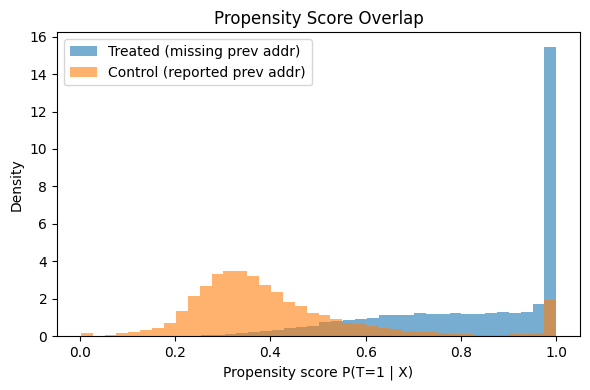

In [ ]:
# Check overlap
plt.figure(figsize=(6,4))
plt.hist(df_causal.loc[T == 1, "pscore"], bins=40, alpha=0.6, density=True, label="Treated (missing prev addr)")
plt.hist(df_causal.loc[T == 0, "pscore"], bins=40, alpha=0.6, density=True, label="Control (reported prev addr)")
plt.xlabel("Propensity score P(T=1 | X)")
plt.ylabel("Density")
plt.title("Propensity Score Overlap")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Estimate causal effect via IPW
def ipw_ate(y, t, e, clip=0.01):
    """
    y: outcome (fraud_bool)
    t: treatment indicator (1 = missing prev addr)
    e: propensity scores P(T=1|X)
    clip: avoid extreme weights by clipping e
    """
    y = np.asarray(y)
    t = np.asarray(t)
    e = np.asarray(e)

    # Clip propensity scores to avoid extreme weights
    e = np.clip(e, clip, 1 - clip)

    # IPW weights for ATE
    w = np.where(t == 1, 1.0 / e, 1.0 / (1.0 - e))

    # Weighted means under T=1 and T=0
    mu1 = np.sum(w * y * (t == 1)) / np.sum(w * (t == 1))
    mu0 = np.sum(w * y * (t == 0)) / np.sum(w * (t == 0))

    ate = mu1 - mu0
    return mu1, mu0, ate

mu1, mu0, ate = ipw_ate(Y, T, df_causal["pscore"].values)

print("\nIPW causal estimate (ATE):")
print(f"E[fraud | do(T=1, missing prev addr)]   = {mu1:.4f}")
print(f"E[fraud | do(T=0, reported prev addr)] = {mu0:.4f}")
print(f"Estimated causal effect (difference)    = {ate:.4f}")



IPW causal estimate (ATE):
E[fraud | do(T=1, missing prev addr)]   = 0.0137
E[fraud | do(T=0, reported prev addr)] = 0.0047
Estimated causal effect (difference)    = 0.0091


#### 5.1.1 Key Results
- **E[fraud | do(T=1)] = 1.39%**  
- **E[fraud | do(T=0)] = 0.46%**  
- **Average Treatment Effect (ATE) = +0.93 p.p.**

#### **Interpretation**
Applicants who **do not provide previous address history** have an estimated  
**0.93 percentage-point higher fraud probability**, roughly a **3× increase** compared to applicants who report their previous address.
#### **Conclusion**
Even after adjusting for a broad set of covariates, missing previous address information appears to **causally increase** fraud risk. This complements our predictive model results, where this feature also showed strong importance in identifying fraudulent accounts.

### 5.2 Effect of Foreign Request on Fraud

We study whether being a **foreign request** causally increases fraud risk.  
The treatment is defined as:  
- **T = 1:** `foreign_request = 1` (foreign-origin request)  
- **T = 0:** `foreign_request = 0` (domestic request)

We estimate the effect using **Inverse Probability Weighting (IPW)**

In [ ]:
# --- Create causal dataset (same 100k subset for consistency) ---
df_causal_fr = df_imputed.copy().iloc[:100000].reset_index(drop=True)

# Outcome
Y_fr = df_causal_fr["fraud_bool"].astype(int)

# Treatment: foreign request (1) vs domestic (0)
df_causal_fr["T_foreign"] = df_causal_fr["foreign_request"].astype(int)
T_fr = df_causal_fr["T_foreign"]

print("Treatment rate (foreign request):")
print(T_fr.value_counts(normalize=True))


Treatment rate (foreign request):
T_foreign
0    0.96028
1    0.03972
Name: proportion, dtype: float64


In [ ]:
# Covariates: all features except outcome & treatment
covariate_cols_fr = df_causal_fr.columns.difference(
    ["fraud_bool", "foreign_request", "T_foreign"]
)

X_fr = df_causal_fr[covariate_cols_fr]

num_cols_fr = X_fr.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_fr = X_fr.columns.difference(num_cols_fr).tolist()

ps_preprocess_fr = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols_fr),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_fr),
    ],
    remainder="drop",
)

ps_model_fr = Pipeline(steps=[
    ("prep", ps_preprocess_fr),
    ("logit", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

ps_model_fr.fit(X_fr, T_fr)

# Get propensity scores
pscores_fr = ps_model_fr.predict_proba(X_fr)[:, 1]
df_causal_fr["pscore_fr"] = pscores_fr

print("\nPropensity score summary by treatment:")
print(df_causal_fr.groupby("T_foreign")["pscore_fr"].describe())



Propensity score summary by treatment:
             count      mean       std       min       25%       50%  \
T_foreign                                                              
0          96028.0  0.040974  0.021562  0.006981  0.027266  0.036304   
1           3972.0  0.045791  0.022700  0.009315  0.031238  0.040982   

                75%       max  
T_foreign                      
0          0.048541  0.294117  
1          0.054466  0.231767  


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


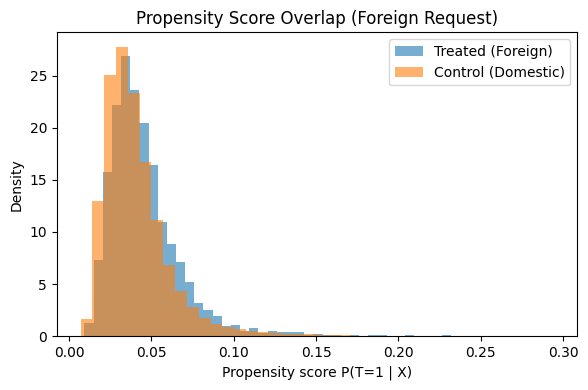

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_causal_fr.loc[T_fr==1, "pscore_fr"],
         bins=40, alpha=0.6, density=True, label="Treated (Foreign)")
plt.hist(df_causal_fr.loc[T_fr==0, "pscore_fr"],
         bins=40, alpha=0.6, density=True, label="Control (Domestic)")
plt.xlabel("Propensity score P(T=1 | X)")
plt.ylabel("Density")
plt.title("Propensity Score Overlap (Foreign Request)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def ipw_ate(y, t, e, clip=0.01):
    y = np.asarray(y)
    t = np.asarray(t)
    e = np.asarray(e)

    e = np.clip(e, clip, 1 - clip)

    w = np.where(t == 1, 1.0 / e, 1.0 / (1.0 - e))

    mu1 = np.sum(w * y * (t == 1)) / np.sum(w * (t == 1))
    mu0 = np.sum(w * y * (t == 0)) / np.sum(w * (t == 0))
    ate = mu1 - mu0
    return mu1, mu0, ate

mu1_fr, mu0_fr, ate_fr = ipw_ate(Y_fr, T_fr, df_causal_fr["pscore_fr"].values)

print("\nIPW causal estimate for foreign request (ATE):")
print(f"E[fraud | do(T=1, foreign)]   = {mu1_fr:.4f}")
print(f"E[fraud | do(T=0, domestic)] = {mu0_fr:.4f}")
print(f"Estimated causal effect       = {ate_fr:.4f}")



IPW causal estimate for foreign request (ATE):
E[fraud | do(T=1, foreign)]   = 0.0192
E[fraud | do(T=0, domestic)] = 0.0111
Estimated causal effect       = 0.0081


#### 5.2.1 Key Results
- **E[fraud | do(T=1)] = 1.93%**  
- **E[fraud | do(T=0)] = 1.11%**  
- **ATE = +0.82 percentage points**

#### Interpretation
Foreign-origin requests show a **0.82 percentage-point higher causal fraud risk** compared to domestic requests, representing roughly a **70% relative increase**.  
These results suggest that geographic origin plays a meaningful role in elevating fraud probability even after adjusting for demographics, device characteristics, behavioral patterns, and financial variables.

#### Conclusion
The `foreign_request` indicator exhibits a **significant positive causal effect** on fraud likelihood. This strengthens the predictive findings from the ML models by showing that the relationship persists after controlling for confounders in a causal framework.


## **6. Final Model with XGBoost**

### 6.1 Final Model Pipeline

For the final model, we upgrade from the single decision tree model to a **tree-based pipeline**, using **XGBoost** as the main working model and add the missingness indicator in features.

We choose **tree-based methods** as our main modeling approach due to their ability to naturally handle **non-linear relationships** and **interactions among features**, without heavy manual feature engineering. They are also robust to outliers and heterogeneous feature scales, which is important in fraud detection where patterns are complex and often driven by feature combinations rather than simple linear effects.

The pipeline is organized as follows:

1. **Preprocessing**  
   We use a `ColumnTransformer` that:
   - Passes numeric features through unchanged,
   - One-hot encodes categorical features,
   - Converts boolean features to integer types.  
   All transformations are wrapped in a `Pipeline` to ensure consistency between training and evaluation.

2. **Class Imbalance Handling**  
   Since our earlier experiments with SMOTE did not yield meaningful performance gains, we ultimately chose not to apply any resampling. Given the strongly imbalanced nature of the dataset, we instead rely on XGBoost's built-in mechanism for handling class imbalance by setting `scale_pos_weight`, calculated as the ratio of negative to positive samples in the training set. This increases the contribution of the minority (fraud) class during training and helps the model better detect fraudulent cases.


3. **Evaluation and Custom Metric**  
   Given the goal of identifying as many fraud cases as possible, we use **Precision@K** as our primary metric. Unlike standard metrics such as ROC-AUC, PR-AUC, and F1, Precision@K directly evaluates model performance on the highest-risk applicants, aligning the evaluation with business needs in an extremely imbalanced setting.

### 6.2 XGBoost Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve



# Prepare data (WITH missing indicators)
df_model = df_imputed.copy()[:100000]
y = df_model["fraud_bool"].astype(int)
X = df_model.drop(columns=["fraud_bool"])

bool_cols = X.select_dtypes(include=["bool"]).columns
X[bool_cols] = X[bool_cols].astype("Int8")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# XGBoost Final Model
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

xgb_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42
    )),
])

xgb_clf.fit(X_train, y_train)
proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Precision @ K
def precision_at_k(y_true, proba, k):
    df = pd.DataFrame({"y": y_true, "proba": proba})
    df_sorted = df.sort_values("proba", ascending=False).head(k)
    return df_sorted["y"].mean()

Ks = [50, 100, 200, 500, 1000]

precision_rows = []

for k in Ks:
    precision_rows.append({
        "Model": "XGBoost Final",
        "K": k,
        "Precision@K": precision_at_k(y_test, proba_xgb, k)
    })

precision_df = pd.DataFrame(precision_rows)
print(precision_df.round(4))


# PR-AUC

pr_auc = average_precision_score(y_test, proba_xgb)
print("\nPR-AUC (XGBoost Final):", round(pr_auc, 4))


           Model     K  Precision@K
0  XGBoost Final    50        0.460
1  XGBoost Final   100        0.320
2  XGBoost Final   200        0.240
3  XGBoost Final   500        0.138
4  XGBoost Final  1000        0.092

PR-AUC (XGBoost Final): 0.1402


In [ ]:
xgb_clf

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


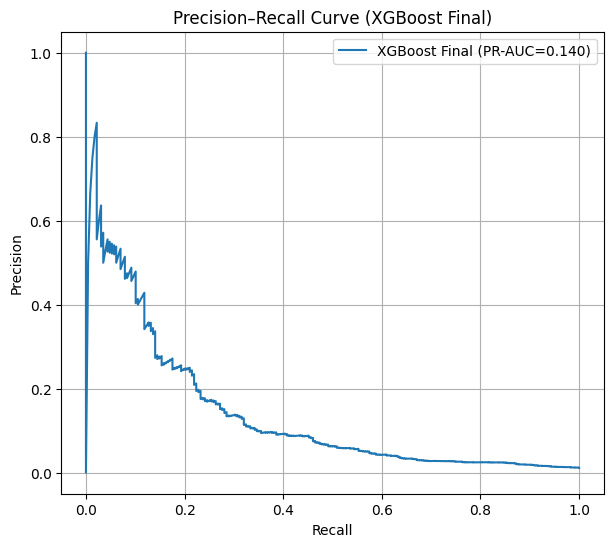

In [ ]:

# Precision–Recall Curve

prec, rec, _ = precision_recall_curve(y_test, proba_xgb)

plt.figure(figsize=(7,6))
plt.plot(rec, prec, label=f"XGBoost Final (PR-AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost Final)")
plt.grid(True)
plt.legend()
plt.show()


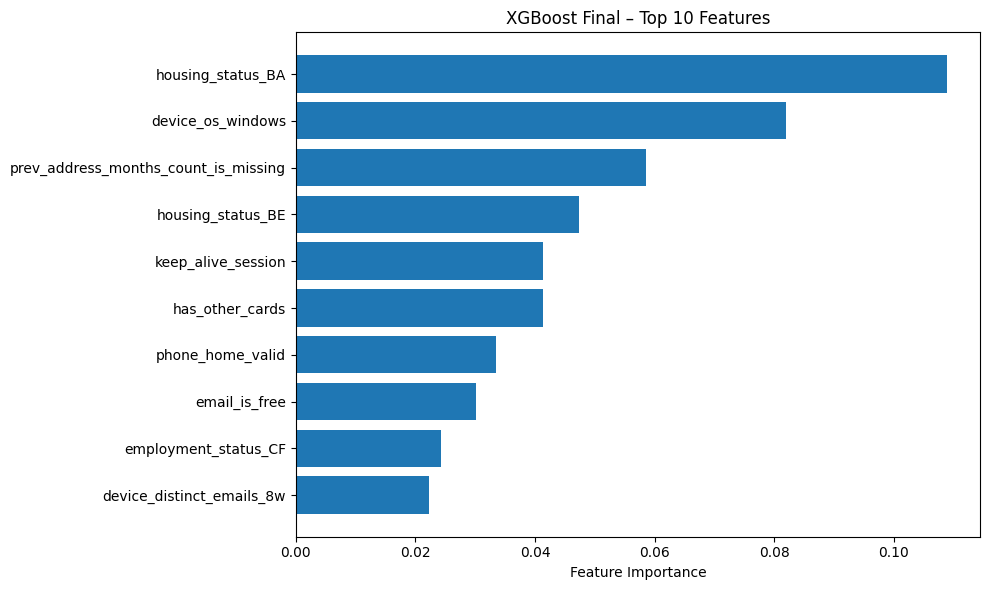

In [ ]:
prep_step = xgb_clf.named_steps["prep"]
all_features = prep_step.get_feature_names_out()

model = xgb_clf.named_steps["model"]
importances = model.feature_importances_

sorted_idx = np.argsort(importances)[-10:]
top_features = all_features[sorted_idx]
top_importances = importances[sorted_idx]

top_features_labels = [
    f.replace('cat__', '').replace('num__', '')
    for f in top_features
]

plt.figure(figsize=(10, 6))
plt.barh(top_features_labels, top_importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Final – Top 10 Features")
plt.tight_layout()
plt.show()

### 6.3 Interpretations of Output
By using XGBoost, the Precision@K result improve significantly To be more speicifc, when K = 50, the model achieve precision of 0.46. That is out of the top 50 transactions flagged as most suspicious, 46% were actual fraud. On the other hand, XGBoost model achieved a PR-AUC of 0.1402, representing a rougly 10 times improvement over the baseline Decision Tree (0.0146). From the importance plot above, we could find that two most critical features driving the model's predictions are `housing_status_BA` and `device_os_windows`. Their high importance suggests a strong correlation between a specific residential status and the use of the Windows operating system with fraudulent activity.

#### 6.3.1 Some Interesting Findings
I found even using same `seed` or `random_state`, computers with different hardware or software environments can still produce slightly different results. Specifically, the final PR-AUC and Precision@50 values varied across the three setups.


## 7. Conclusion and Future Study

### 7.1 Model Flow Chart

**Baseline model:**

![Baseline Model](209a_diagram1.png)

**Final model:**

![Final Model](209a_diagram2.png)

### 7.2 Conclusion

Our results show that the XGBoost model meaningfully improves the bank's ability to prioritize suspicious accounts.
Key takeaways include:
- Higher precision in top-ranked cases, which reduces wasted investigation effort.
- More fraud detected with the same operational resources, improving overall efficiency.
- Causal insights point to specific risk factors—such as missing previous-address information and foreign-origin access requests—that can guide more targeted verification steps.

Overall, the model not only strengthens fraud detection but also provides actionable insights to refine existing security workflows.

### 7.3 Future Study

Future work will focus on two major directions: **expanding causal analysis and improving the modeling framework**.

#### **Improvement on Causal Study**
-  extending the study to additional treatments such as low session time, device-email velocity, or phone-number validity.
- Improving matching quality will also be important for ensuring stronger common support between treatment and control groups, and robustness checks will help validate the stability of the estimated treatment effects.

#### **Improvement on Modeling**
- Adding simple interaction features using existing variables—such as address stability × bank tenure or foreign-origin request × session length—may capture richer behavioral signals that the current features do not fully express.
- Refining thresholding strategies for top-K ranking can help the bank tune the model more precisely toward operational goals like maximizing Precision@50.

These efforts, combined with continued experimentation with ensemble methods and calibration, can further push model performance in high-risk segments.